# The Best Neighborhood in Pittsburgh

In [7]:
import pandas as pd
import numpy as np

education = pd.read_csv("neighborhood_iep.csv")
arrest_data = pd.read_csv("Police Arrest Data.csv")
parks = pd.read_csv("parks.csv")

neighborhoods_k12 = pd.DataFrame(columns=['Neighborhood', 'K12 Enrollment'])

for i in range(len(education)):
    neighborhood_str = education.iloc[i]['neighborhoods']
    k12 = education.iloc[i]['total_enrollment_k_12']
    neighborhoods_list = neighborhood_str.split(', ')
    neighborhood = neighborhoods_list[0].strip()
    
    # Create a new row for each neighborhood and append to the new dataframe
    for neighborhood in neighborhoods_list:
        neighborhoods_k12.loc[len(neighborhoods_k12)] = [neighborhood, k12]

# Define weights for each metric
arrest_weight = 0.4
k12_weight = 0.3
park_weight = 0.3

arrest_ranking = arrest_data["INCIDENTNEIGHBORHOOD"].value_counts().sort_values(ascending=True)
k12_ranking = neighborhoods_k12.groupby('Neighborhood')['K12 Enrollment'].sum().sort_values(ascending=False)
park_ranking = parks["neighborhood"].value_counts().sort_values(ascending=False)

# Select the top 20 neighborhoods for each metric
top100_arrest = arrest_ranking.iloc[:100]
top100_k12 = k12_ranking.iloc[:100]
top100_park = park_ranking.iloc[:100]

# Calculate total score for each neighborhood
# the "scores" is a normalized measure of the number of arrests/k12/parks in each neighborhood, which allows for comparison of neighborhoods.
neighborhood_scores = pd.DataFrame(index=top100_arrest.index)
neighborhood_scores["Arrest_score"] = 100 * (top100_arrest.max() - top100_arrest) / (top100_arrest.max() - top100_arrest.min())
neighborhood_scores["K12_score"] = 100 * (1 - ((top100_k12.max() - top100_k12) / (top100_k12.max() - top100_k12.min())))
neighborhood_scores["Park_score"] = 100 * (1 - ((top100_park.max() - top100_park) / (top100_park.max() - top100_park.min())))
neighborhood_scores["Total_score"] = (neighborhood_scores["Arrest_score"] * arrest_weight
                                       + neighborhood_scores["K12_score"] * k12_weight
                                       + neighborhood_scores["Park_score"] * park_weight)

best_neighborhoods = neighborhood_scores.sort_values("Total_score", ascending=False).iloc[:5]
print(best_neighborhoods)


                     Arrest_score  K12_score  Park_score  Total_score
East Liberty            54.218461  50.762712  100.000000    66.916198
Beechview               70.536895  54.322034   63.636364    63.602277
Squirrel Hill South     79.661465  54.406780   45.454545    61.822984
Swisshelm Park          98.994975  54.406780   18.181818    61.374569
Point Breeze            92.462312  16.694915   54.545455    58.357036


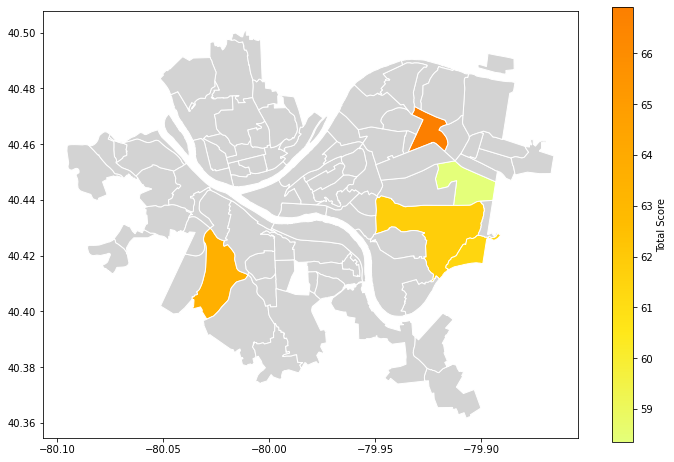

In [6]:
import geopandas

neighborhoods = geopandas.read_file("Neighborhoods/Neighborhoods_.shp")
# do the merge
best_neighborhood_map = neighborhoods.merge(best_neighborhoods, how='left', left_on='hood', right_index=True)
# look at the head to confirm it merged correctly
best_neighborhood_map[['hood','total_score','geometry']].head()

best_neighborhood_map.plot(column='total_score', # set the data to be used for coloring
               cmap='Wistia',              # choose a color palette
               edgecolor="white",        # outline the districts in white
               legend=True,              # show the legend
               legend_kwds={'label': "Total Score"}, # label the legend
               figsize=(12, 8),         # set the size
               missing_kwds={"color": "lightgrey"} # set disctricts with no data to gray
               )